In [1]:
cd ..

/home/jovyan/Dropbox/Public/dsi-plus/s_p500


In [2]:
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from functools import partial
%matplotlib inline

# Recursive function

In [195]:
def connect_line(arr, span_tuple):
    '''
    Compute lambda function for a line that connects two values from arr.
    
    Inputs:
    - arr: numpy 1d-array of time-series values
    - span_tuple: start and enpdpoints for line
    '''
    first, last = span_tuple
    run = last - first
    rise = arr[last] - arr[first]
    slope = rise / run
    intercept = arr[first] - first * slope
    
    return lambda x: intercept + slope * x


def line_point_distance(arr, x1, x2, x0):
    '''
    Calculate the minimal orthogonal distance from a line connecting
    (x1, arr[x1]) and (x2, arr[x2]) to a third point (x0, arr[x0])
    
    Distance formula from https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line.
    
    Inputs:
    - arr: numpy 1d-array of time-series values
    - x1: int, start x-value of line
    - x2: int, end x-value of line
    - x3: int, third point for distance to be calculated
    '''
    y1 = arr[x1]
    y2 = arr[x2]
    y0 = arr[x0]
    
    numerator = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
    
    return numerator / denominator


def farthest_point(arr, x1, x2):
    '''
    Find the farthest point between two points that define a line on a time-series.
    '''
    xx = np.arange(len(arr))
    
    distances_partial = partial(line_point_distance, arr, x1, x2)
    distances = distances_partial(xx)
    mask = (xx > x1) & (xx < x2)
    farthest_point_indx = np.argmax(distances[mask]) + x1 
    max_distance = distances[farthest_point_indx]
    
    return farthest_point_indx, max_distance

In [194]:
def flatten(nested):
    '''
    Flatten nested lists
    '''
    flattened = []
    for item in nested:
        if type(item) != list:
            flattened.append(item)
        else:
            flattened += flatten(item)
    return flattened


def plr_recursive(arr, span_tuple, epsilon):
    '''
    Compute piece-wise linear regression on a time series.
    
    Inputs:
    - arr: numpy 1d-array of time-series values
    - span_tuple: start and endpoints
    - epsilon: threshold for line-breaking
    
    Outputs:
    - lines: list of lambda functions
    - points: list of points that dicate when lambdas should be used
    '''
    first, last = span_tuple
    farthest_indx, distance = farthest_point(arr, first, last)
    
    lines = []
    points = []
        
    if distance < epsilon: #base case
        line = connect_line(arr, span_tuple)
        point = first
        
        return line, point
    
    else: #recursive case
       
        line_1, point_1 = plr_recursive(arr, (first, farthest_indx), epsilon)
        line_2, point_2 = plr_recursive(arr, (farthest_indx, last), epsilon)
        
        lines.extend([line_1, line_2])
        points.extend([point_1, point_2])
        
        #flatten out recursive nests
        return flatten(lines), flatten(points) 

def PLR(arr, epsilon):
    '''
    Compute full PLR for a time series
    '''
    xx = np.arange(len(arr))
    lines, points = plr_recursive(arr, (0, len(arr) -1), epsilon)
    plr_values = np.piecewise(xx, [xx >= point for point in points], funcs)
    
    return plr_values

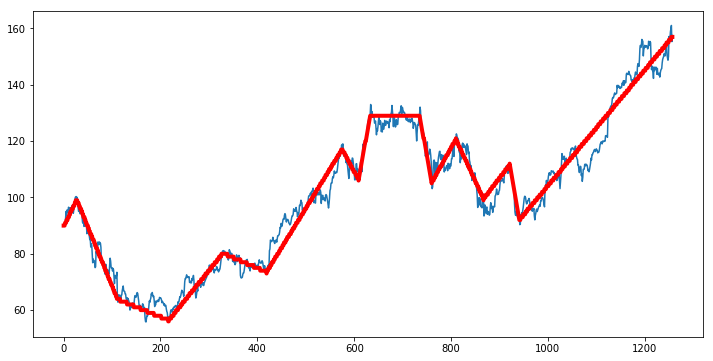

In [196]:
xx = np.arange(len(apple))
plt.figure(figsize=(12,6))
plt.plot(xx, apple["Close"])
plt.plot(xx, PLR(closes, 12), linewidth = 4, c= "red")
#plt.plot(xx, line_2(xx), linewidth = 4)